In [1]:
!pip install torch torchvision torchaudio numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to range [-1, 1]
])

In [28]:


# Define transformations for MNIST dataset (normalize and reshape)


# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## CIFAR_10

In [3]:
# Define transformations for CIFAR-10 dataset (normalize and reshape)
cifar_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to range [-1, 1]
])

# Load CIFAR-10 dataset
cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)
cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, transform=cifar_transform, download=True)

cifar_train_loader = torch.utils.data.DataLoader(dataset=cifar_train_dataset, batch_size=64, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(dataset=cifar_test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the autoencoder model
class CIFARAutoencoder(nn.Module):
    def __init__(self):
        super(CIFARAutoencoder, self).__init__()
        # the encoder last layer should be linear which makes the encoding a vector
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # [batch_size, 64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # [batch_size, 128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # [batch_size, 256, 4, 4]
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # [batch_size, 512, 2, 2]
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=2, stride=1),  # [batch_size, 512, 1, 1]
            nn.Flatten(),  # [batch_size, 512*1*1]
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 1, 1)),  # [batch_size, 512, 1, 1]
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=1),  # [batch_size, 512, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 256, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 3, 32, 32]
            nn.Sigmoid(),  # To ensure the output is in range [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Define your model
cifar_autoencoder = CIFARAutoencoder().to(device)

# Loss function and optimizer with L2 regularization (weight decay)
criterion = nn.MSELoss()
optimizer = optim.Adam(cifar_autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler - reduce LR when a plateau is detected in validation loss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early stopping configuration
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Training and validation loops
num_epochs = 100  # You can make this larger since early stopping will prevent overfitting
train_losses, val_losses = [], []

/home/aditya_sridhar/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
for epoch in range(num_epochs):
    cifar_autoencoder.train()
    running_loss = 0.0
    
    # Training loop
    for data in tqdm(cifar_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, _ = data
        inputs = inputs.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        outputs = cifar_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss
    train_loss = running_loss / len(cifar_train_loader)
    train_losses.append(train_loss)

    # Validation loop
    cifar_autoencoder.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for data in cifar_test_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            outputs = cifar_autoencoder(inputs)
            val_loss = criterion(outputs, inputs)

            val_running_loss += val_loss.item()

    # Average validation loss
    val_loss = val_running_loss / len(cifar_test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cifar_autoencoder.state_dict(), 'best_cifar_autoencoder.pth')  # Save the best model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Step scheduler
    scheduler.step(val_loss)

# Save the final model (you can save the best model as well)
torch.save(cifar_autoencoder.state_dict(), 'final_cifar_autoencoder.pth')


Epoch 1/100: 100%|██████████| 782/782 [02:18<00:00,  5.66it/s]


Epoch [1/100], Train Loss: 0.2329, Validation Loss: 0.1891


Epoch 2/100: 100%|██████████| 782/782 [02:05<00:00,  6.21it/s]


Epoch [2/100], Train Loss: 0.1847, Validation Loss: 0.1778


Epoch 3/100: 100%|██████████| 782/782 [02:20<00:00,  5.58it/s]


Epoch [3/100], Train Loss: 0.1766, Validation Loss: 0.1710


Epoch 4/100: 100%|██████████| 782/782 [02:32<00:00,  5.14it/s]


Epoch [4/100], Train Loss: 0.1717, Validation Loss: 0.1675


Epoch 5/100: 100%|██████████| 782/782 [02:46<00:00,  4.68it/s]


Epoch [5/100], Train Loss: 0.1682, Validation Loss: 0.1640


Epoch 6/100:  60%|█████▉    | 467/782 [01:54<01:17,  4.09it/s]


KeyboardInterrupt: 

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    cifar_autoencoder.train()
    running_loss = 0.0
    for data in cifar_train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cifar_autoencoder(inputs)
        # print(outputs.shape, inputs.shape)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(cifar_train_loader):.4f}')

# Save the trained model
torch.save(cifar_autoencoder.state_dict(), 'cifar_autoencoder.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input d

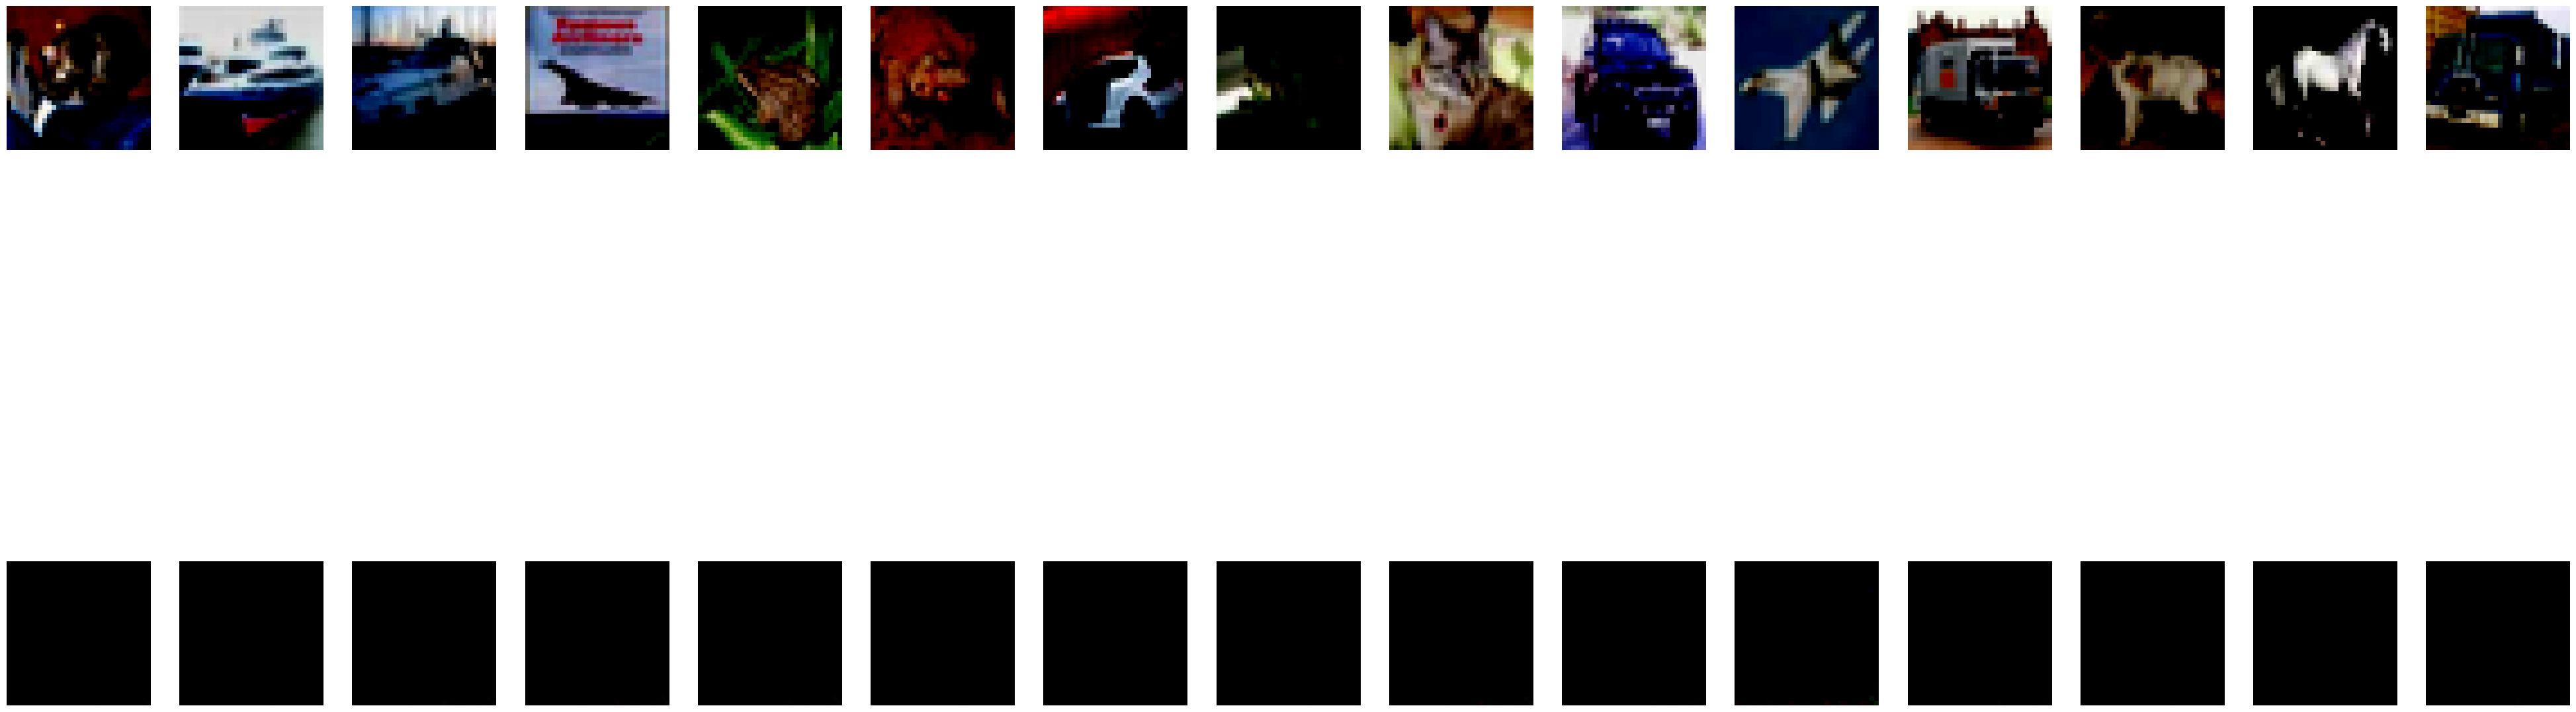

In [13]:
# Show 15 random images from the test set and their reconstructions
cifar_autoencoder.eval()

fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(50, 20))
for images, _ in cifar_test_loader:
    reconstructions = cifar_autoencoder(images.to(device)).detach().cpu()
    images = images.numpy()
    reconstructions = reconstructions.numpy()
    for i in range(15):
        axes[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(reconstructions[i], (1, 2, 0)))
        axes[1, i].axis('off')
    break

In [ ]:
# Now, feature visualization: For this, we will use the encoder part of the autoencoder. 
# Pass each image through the encoder and store its encoding.
# Choose the top 10 features that are activated the most and visualize the top 10 images that activate that feature the most.
# Plot a 10x10 grid of images where each row corresponds to a feature and each column corresponds to an image that activates that feature the most.

# Load the trained model
cifar_autoencoder.load_state_dict(torch.load('cifar_autoencoder.pth'))
cifar_autoencoder.eval()

# Get the encoder part of the model
cifar_encoder = cifar_autoencoder.encoder

# Get the test images and their encodings
encodings = []
for images, _ in cifar_test_loader:
    encodings.append(cifar_encoder(images.to(device)).detach().cpu())
encodings = torch.cat(encodings)

# Get the top 10 images that activate each feature the most
top_images = []
fifteen_random_feature_indices = torch.randint(0, 512, (50,))
for i in fifteen_random_feature_indices:
    top_images.append(encodings[:, i].topk(10).indices)
top_images = torch.stack(top_images)

# Plot the top 10 images that activate each feature the most
fig, axes = plt.subplots(nrows=512, ncols=10, figsize=(10, 512))
for i in range(len(fifteen_random_feature_indices)):
    for j in range(10):
        axes[i, j].imshow(np.transpose(cifar_test_dataset[top_images[fifteen_random_feature_indices[i], j]][0], (1, 2, 0)))
        axes[i, j].axis('off')

plt.show()

### Joint Autoencoder-Classifier

In [28]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Define the joint model
class CIFARJointModel(nn.Module):
    def __init__(self):
        super(CIFARJointModel, self).__init__()
        self.encoder = CIFARAutoencoder().encoder  # Use encoder from autoencoder
        self.decoder = CIFARAutoencoder().decoder  # Use decoder from autoencoder
        self.classifier = nn.Linear(512, 10)  # Classifier with output of 10 classes

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classification = self.classifier(encoded)
        return decoded, classification

# Initialize the model, loss functions, and optimizer with weight decay
cifar_joint_model = CIFARJointModel().to(device)
reconstruction_criterion = nn.MSELoss()  # Reconstruction loss
classification_criterion = nn.CrossEntropyLoss()  # Classification loss
optimizer = optim.Adam(cifar_joint_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler and early stopping configurations
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

/home/aditya_sridhar/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [29]:
num_epochs = 100
train_losses, val_losses = [], []

# Training loop
for epoch in range(num_epochs):
    cifar_joint_model.train()
    running_loss = 0.0
    
    # Training loop
    for inputs, labels in tqdm(cifar_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        outputs, classification = cifar_joint_model(inputs)
        
        # Compute losses
        reconstruction_loss = reconstruction_criterion(outputs, inputs)
        classification_loss = classification_criterion(classification, labels)
        
        # Joint loss (reconstruction + classification)
        loss = reconstruction_loss + classification_loss
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss for the epoch
    train_loss = running_loss / len(cifar_train_loader)
    train_losses.append(train_loss)
    
    # Validation loop to evaluate the model
    cifar_joint_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in cifar_test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs, classification = cifar_joint_model(inputs)

            # Validation losses
            reconstruction_loss = reconstruction_criterion(outputs, inputs)
            classification_loss = classification_criterion(classification, labels)

            val_loss = reconstruction_loss + classification_loss
            val_running_loss += val_loss.item()

    # Average validation loss
    val_loss = val_running_loss / len(cifar_test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping mechanism
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(cifar_joint_model.state_dict(), 'best_cifar_joint_model.pth')  # Save the best model
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Learning rate scheduler step
    scheduler.step(val_loss)

# Save the final model
torch.save(cifar_joint_model.state_dict(), 'final_cifar_joint_model.pth')

Epoch 1/100:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 782/782 [02:14<00:00,  5.83it/s]


Epoch [1/100], Train Loss: 1.8969, Validation Loss: 1.6084


Epoch 2/100: 100%|██████████| 782/782 [02:10<00:00,  6.01it/s]


Epoch [2/100], Train Loss: 1.5367, Validation Loss: 1.4496


Epoch 3/100: 100%|██████████| 782/782 [02:12<00:00,  5.90it/s]


Epoch [3/100], Train Loss: 1.3933, Validation Loss: 1.3673


Epoch 4/100: 100%|██████████| 782/782 [02:26<00:00,  5.35it/s]


Epoch [4/100], Train Loss: 1.2811, Validation Loss: 1.2684


Epoch 5/100: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]


Epoch [5/100], Train Loss: 1.1878, Validation Loss: 1.2283


Epoch 6/100: 100%|██████████| 782/782 [03:18<00:00,  3.93it/s]


Epoch [6/100], Train Loss: 1.1042, Validation Loss: 1.1609


Epoch 7/100: 100%|██████████| 782/782 [03:25<00:00,  3.80it/s]


Epoch [7/100], Train Loss: 1.0249, Validation Loss: 1.1359


Epoch 8/100: 100%|██████████| 782/782 [03:09<00:00,  4.12it/s]


Epoch [8/100], Train Loss: 0.9522, Validation Loss: 1.1121


Epoch 9/100: 100%|██████████| 782/782 [03:08<00:00,  4.14it/s]


Epoch [9/100], Train Loss: 0.8775, Validation Loss: 1.1087


Epoch 10/100: 100%|██████████| 782/782 [03:05<00:00,  4.21it/s]


Epoch [10/100], Train Loss: 0.8029, Validation Loss: 1.1045


Epoch 11/100: 100%|██████████| 782/782 [02:53<00:00,  4.50it/s]


Epoch [11/100], Train Loss: 0.7239, Validation Loss: 1.1104


Epoch 12/100: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s]


Epoch [12/100], Train Loss: 0.6491, Validation Loss: 1.1336


Epoch 13/100: 100%|██████████| 782/782 [02:42<00:00,  4.82it/s]


Epoch [13/100], Train Loss: 0.5690, Validation Loss: 1.1926


Epoch 14/100: 100%|██████████| 782/782 [02:32<00:00,  5.12it/s]


Epoch [14/100], Train Loss: 0.4995, Validation Loss: 1.2554


Epoch 15/100: 100%|██████████| 782/782 [02:47<00:00,  4.67it/s]


Epoch [15/100], Train Loss: 0.4285, Validation Loss: 1.3151


Epoch 16/100: 100%|██████████| 782/782 [02:49<00:00,  4.62it/s]


Epoch [16/100], Train Loss: 0.3709, Validation Loss: 1.4114


Epoch 17/100: 100%|██████████| 782/782 [03:02<00:00,  4.29it/s]


Epoch [17/100], Train Loss: 0.2634, Validation Loss: 1.5299


Epoch 18/100: 100%|██████████| 782/782 [03:12<00:00,  4.07it/s]


Epoch [18/100], Train Loss: 0.2320, Validation Loss: 1.6324


Epoch 19/100: 100%|██████████| 782/782 [03:13<00:00,  4.04it/s]


Epoch [19/100], Train Loss: 0.2139, Validation Loss: 1.7497


Epoch 20/100: 100%|██████████| 782/782 [03:15<00:00,  4.00it/s]


Epoch [20/100], Train Loss: 0.2012, Validation Loss: 1.8478
Early stopping triggered.


/tmp/ipykernel_597609/1664555163.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cifar_joint_model.load_state_dict(torch.load('final_cifar_joint_model.pth'))
Clipping in

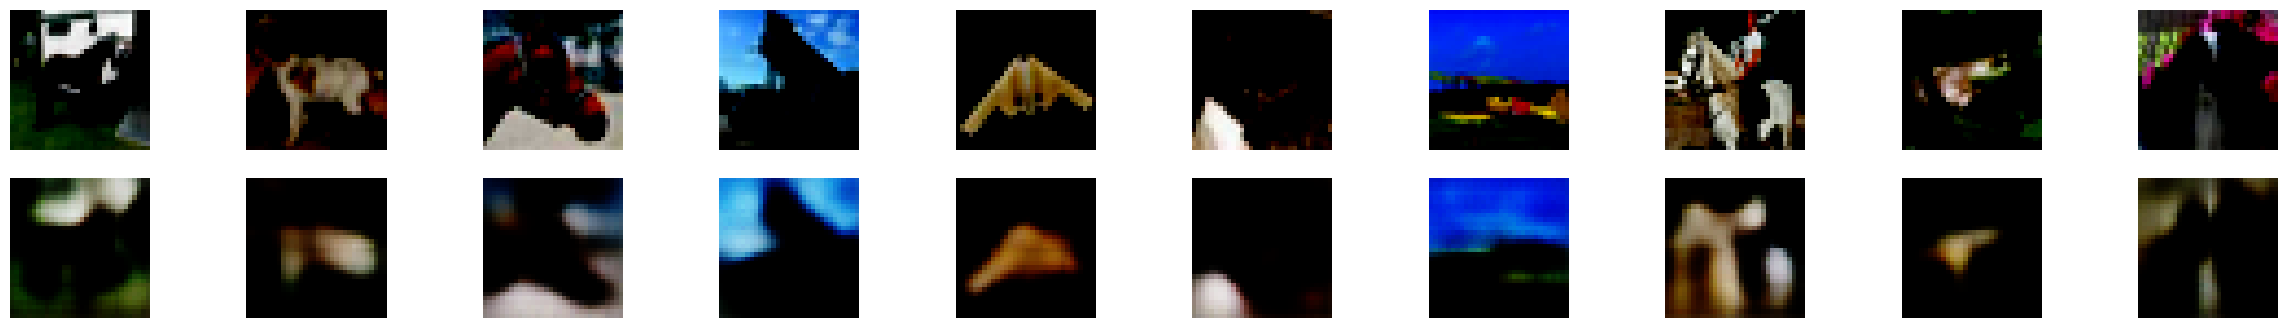

In [56]:
# Now, do the same as before - show 15 random images from the test set and their reconstructions.\
cifar_joint_model.load_state_dict(torch.load('final_cifar_joint_model.pth'))
cifar_joint_model.eval()


fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(30, 4))
random_indices = torch.randint(0, 64, (10,))
for images, _ in cifar_test_loader:
    reconstructions, _ = cifar_joint_model(images.to(device))
    reconstructions = reconstructions.detach().cpu()
    images = images.numpy()
    reconstructions = reconstructions.numpy()
    for i in range(10):
        axes[0, i].imshow(np.transpose(images[random_indices[i]], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(reconstructions[random_indices[i]], (1, 2, 0)))
        axes[1, i].axis('off')
    break

plt.show()

In [37]:
# Now I want you to visualize the top 10 images that activate each feature the most in the joint model.
# This time, you should use the encoder part of the joint model.
# Load the trained model
cifar_encoder = cifar_joint_model.encoder

# Get the test images and their encodings
encodings = []
for images, _ in cifar_test_loader:
    encodings.append(cifar_encoder(images.to(device)).detach().cpu())
encodings = torch.cat(encodings)

# Get the top 10 images that activate each feature the most
top_images = []
for i in range(10):
    top_images.append(encodings[:, i].topk(10).indices)
top_images = torch.stack(top_images)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping in

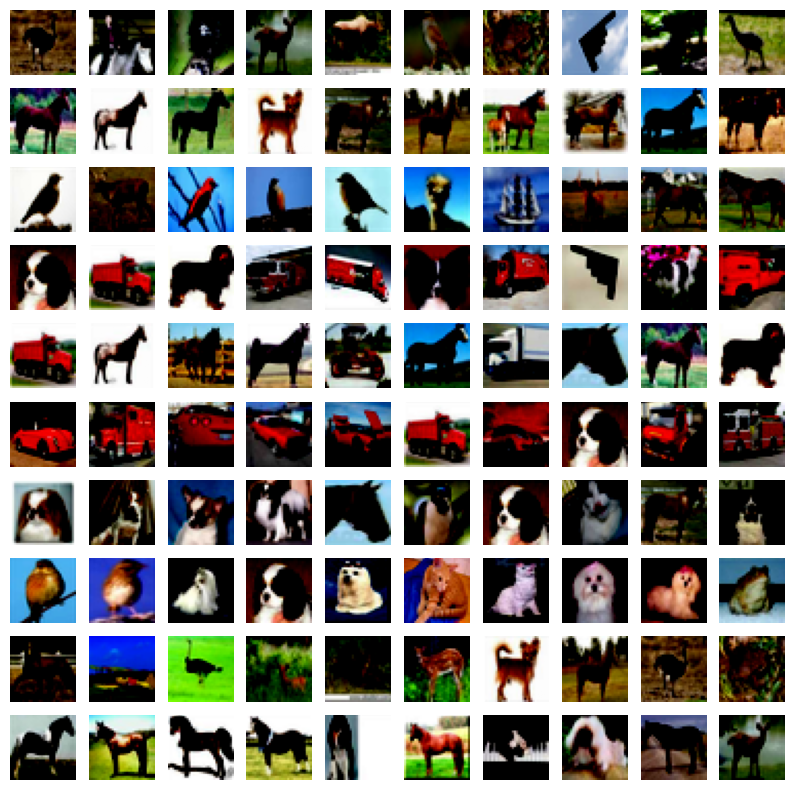

In [57]:

# Plot the top 10 images that activate each feature the most
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(np.transpose(cifar_test_dataset[top_images[i, j]][0], (1, 2, 0)))
        axes[i, j].axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41176468..1.0].
Exception ignored in: <function tqdm.__del__ at 0x7fbe570be9e0>
Traceback (most recent call last):
  File "/home/aditya_sridhar/.local/lib/python3.10/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):
KeyboardInterrupt: 


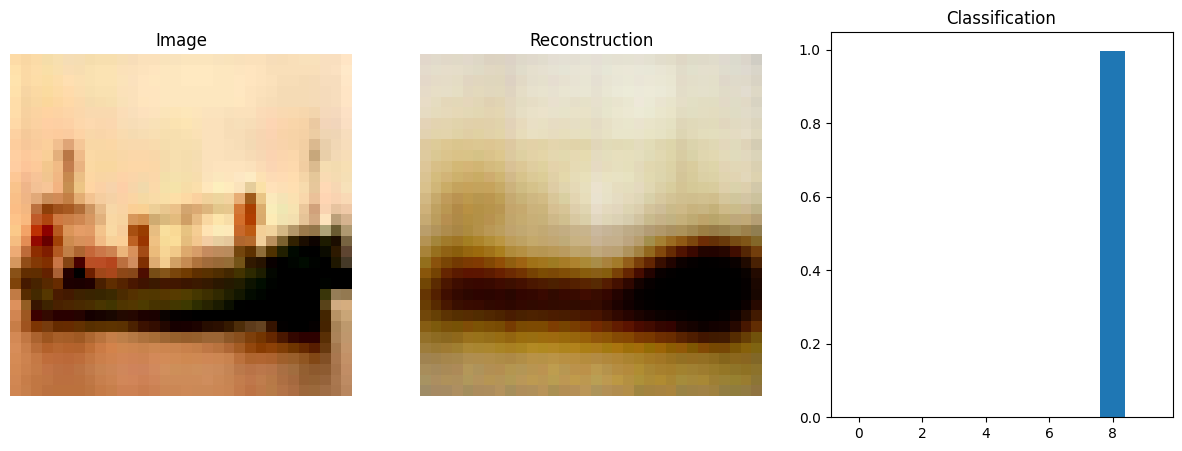

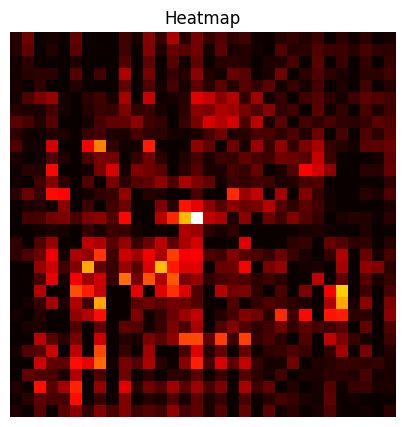

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41176468..1.0].


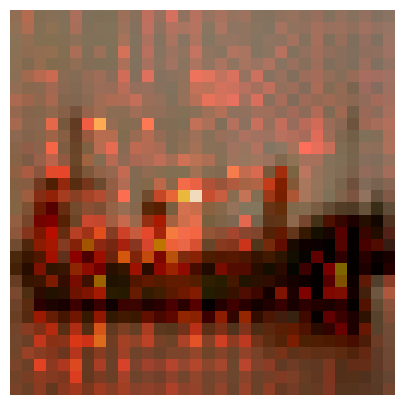

In [77]:
# Now, choose a random image from the test set.
# Pass it through the encoder and get the encoding.
# Pass the encoding through the classifier and get the output.
# Show the image, the reconstruction, and the output of the classifier.
# Now, choose any 5 features out of the 512.
# Compute the activation map of each feature for the image.
# Show the activation map of each feature.

# Choose a random image from the test set
image_number = torch.randint(0, len(cifar_test_dataset), (1,)).item()
image, label = cifar_test_dataset[image_number]
image = image.unsqueeze(0).to(device)
image_copy = image.clone()

# Pass it through the encoder and get the encoding
encoding = cifar_encoder(image).detach()

# Pass the encoding through the classifier and get the output
reconstruction, classification = cifar_joint_model(image)


# Show the image, the reconstruction, and the output of the classifier
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(np.transpose(image.squeeze().cpu(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(np.transpose(reconstruction.squeeze().cpu().detach(), (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title('Reconstruction')
axes[2].bar(range(10), torch.softmax(classification, dim=1).squeeze().cpu().detach())
axes[2].set_title('Classification')
plt.show()


# Choose the feature which has maximum activation for the image
feature = encoding.argmax()

# Compute the gradient of the encoding with respect to the image
image.requires_grad = True
encoding = cifar_encoder(image)
encoding[:, feature].backward()

# Now construct a heatmap of the gradients - 3 heatmaps for each channel
gradients = image.grad.squeeze().cpu().numpy()
heatmap = np.maximum(gradients[0], 0) + np.maximum(gradients[1], 0) + np.maximum(gradients[2], 0)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


# Show the heatmap, along with a label starting from white to black, with white being the highest value
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
axes.imshow(heatmap, cmap='hot')
axes.axis('off')
axes.set_title('Heatmap')
plt.show()

# Now overlay the heatmap on the image
image = image_copy.cpu().numpy()
heatmap = np.uint8(255 * heatmap)
heatmap = plt.get_cmap('hot')(heatmap)[:, :, :3]
heatmap = np.uint8(255 * heatmap)
heatmap = np.transpose(heatmap, (0, 1, 2))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow((np.transpose(image_copy.squeeze().cpu(), (1, 2, 0))))
axes.imshow(heatmap, alpha=0.5)
axes.axis('off')

plt.show()

## MNIST

In [24]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [batch_size, 16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # [batch_size, 32, 7, 7]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)  # [batch_size, 64, 1, 1]
        )
        
        # Latent space (batch_size, 64)
        self.fc = nn.Linear(64, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 32, kernel_size=7),  # [batch_size, 32, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [batch_size, 1, 28, 28]
            nn.Sigmoid()  # To ensure the output is in range [0, 1]
        )

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten for fully connected layer
        latent = self.fc(encoded)  # Latent representation
        
        # Decoder
        latent = latent.view(latent.size(0), latent.size(1), 1, 1)  # Reshape back to [batch_size, latent_dim, 1, 1]
        decoded = self.decoder(latent)
        return decoded

In [29]:
latent_dim = 64
model = ConvAutoencoder(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')



Epoch [1/5], Loss: 0.9733
Epoch [2/5], Loss: 0.9254
Epoch [3/5], Loss: 0.9254


KeyboardInterrupt: 

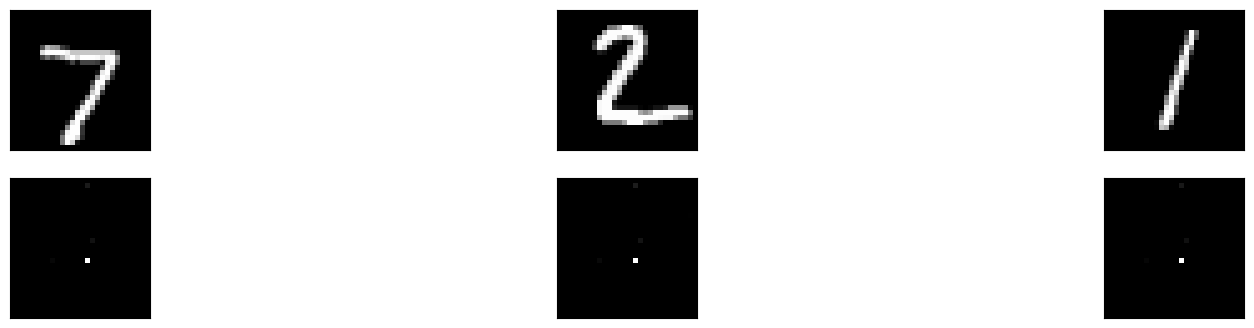

In [26]:

# Test the model and visualize the results
model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    images, _ = next(data_iter)  # Use next() directly
    images = images.to(device)
    reconstructed = model(images)

# Move tensors to CPU and convert to numpy
images = images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot original and reconstructed images
n = 3
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.squeeze(images[i]), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.squeeze(reconstructed[i]), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Save the figure as a file (e.g., .png)
plt.show()
